# **Skin Disease Classification (Tinea Versicolor, Ringworm, Scabies)**

# **Import Library**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [ ]:
print(tf.__version__)

2.8.2


# Import Dataset

In [ ]:
# Extract Zip
import zipfile # Add Library zipfile
local_zip = 'data.zip'
extract_zip = zipfile.ZipFile(local_zip, 'r')
extract_zip.extractall('')
extract_zip.close()

In [ ]:
!ls data/image
!ls data/image/train
!ls data/image/train/Tinea Versicolor
!ls data/image/train/Ringworm
!ls data/image/train/Scabies

test  train
 Ringworm   Scabies  'Tinea Versicolor'
ls: cannot access 'data/image/train/Tinea': No such file or directory
ls: cannot access 'Versicolor': No such file or directory
'images (1).jpg'  'Kadas (16).jpg'  'Kadas (27).jpg'  'Kadas (38).jpg'
'images (2).jpg'  'Kadas (17).jpg'  'Kadas (28).jpg'  'Kadas (39).jpg'
'images (4).jpg'  'Kadas (18).jpg'  'Kadas (29).jpg'  'Kadas (3).jpg'
'images (5).jpg'  'Kadas (19).jpg'  'Kadas (2).jpg'   'Kadas (40).jpg'
'images (6).jpg'  'Kadas (1).jpg'   'Kadas (30).jpg'  'Kadas (41).jpg'
 images.jpg	  'Kadas (20).jpg'  'Kadas (31).jpg'  'Kadas (42).jpg'
'Kadas (10).jpg'  'Kadas (21).jpg'  'Kadas (32).jpg'  'Kadas (4).jpg'
'Kadas (11).jpg'  'Kadas (22).jpg'  'Kadas (33).jpg'  'Kadas (5).jpg'
'Kadas (12).jpg'  'Kadas (23).jpg'  'Kadas (34).jpg'  'Kadas (6).jpg'
'Kadas (13).jpg'  'Kadas (24).jpg'  'Kadas (35).jpg'  'Kadas (7).jpg'
'Kadas (14).jpg'  'Kadas (25).jpg'  'Kadas (36).jpg'  'Kadas (8).jpg'
'Kadas (15).jpg'  'Kadas (26).jpg'  'Kadas (37).j

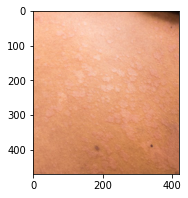

In [ ]:
# Visualize one image from data train
image = imread("data/image/train/Tinea Versicolor/Panu (29).jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [ ]:
# Load all images to memory for the first time

# Load Training Dataset
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.2,
    rotation_range=40,
    height_shift_range=0.2,
    width_shift_range=0.5,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

# Load Testing Dataset
X_test = []
y_test = []
labels = ['Ringworm', 'Scabies', 'Tinea Versicolor']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 117 images belonging to 3 classes.
Found 27 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (117, 224, 224, 3) (117, 3)
Bentuk array dari dataset validation (validasi) adalah: (27, 224, 224, 3) (27, 3)
Bentuk array dari dataset test (pengujian) adalah: (36, 224, 224, 3) (36,)


# **Save Labels**

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Ringworm': 0, 'Scabies': 1, 'Tinea Versicolor': 2}


In [ ]:
!cat labels.txt

Ringworm
Scabies
Tinea Versicolor

# **Create Base Model From Pre-Trained Model**

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG-16Net
base_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

20004864/19993432 [==============================] - 0s 0us/step


# *Summary*

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

# **Feature Extraction**

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.98):
      print("\nAkurasi telah mencapai > 98%!")
      self.model.stop_training = True
mycalls = myCallback()

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu6'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

base_learning_rate = 0.0001
model.compile(tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss="categorical_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          304160    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 4,573,975
Trainable params: 304,259
Non-trainable params: 4,269,716
_________________________________________________________________


## **Training & Visualize**

In [ ]:
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator,
                    callbacks=[mycalls])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
1/1 [==============================] - 27s 27s/step - loss: 1.7273 - acc: 0.2821 - val_loss: 1.4104 - val_acc: 0.2593
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 1.3652 - acc: 0.3333 - val_loss: 1.2203 - val_acc: 0.3704
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 1.1679 - acc: 0.4017 - val_loss: 1.1118 - val_acc: 0.3704
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.0289 - acc: 0.5299 - val_loss: 1.0652 - val_acc: 0.3704
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.9508 - acc: 0.4957 - val_loss: 1.0150 - val_acc: 0.4444
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.8704 - acc: 0.5299 - val_loss: 0.9432 - val_acc: 0.5556
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.7719 - acc: 0.6325 - val_loss: 0.8671 - val_acc: 0.5926
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.6743 - acc: 0.7265 - val_loss:

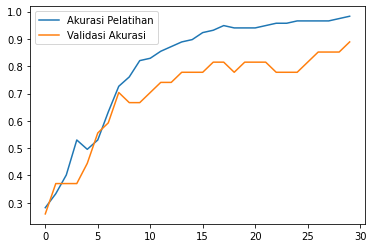

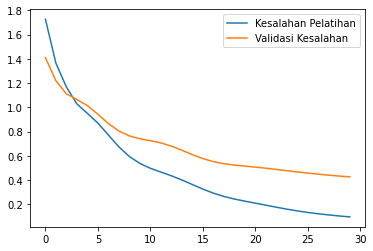

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Using Training Model

In [ ]:
print(train_generator)

In [ ]:
# Prediction Validation Label with Model Training
n = 23
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [9.942213e-01 5.148038e-03 6.306635e-04]


These results are predictions from training from 3 types of training data, namely Ringworm, Scabies, and Tinea Versicolor. Using image input with 224 x 224 pixels, 1 filter with relu activation function, 1 output layer with softmax activation function, 20% dropout, and callback

## **Evaluation**

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
2/2 [==============================] - 4s 235ms/step - loss: 0.3551 - acc: 0.9167
[0.3550967276096344, 0.9166666865348816]


In [ ]:
# Show True Matrix and Prediction Matrix

# True Label
y_true = np.argmax(y_test2,axis=1)

# Prediction Label
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
[1 0 0 0 0 0 0 0 1 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]


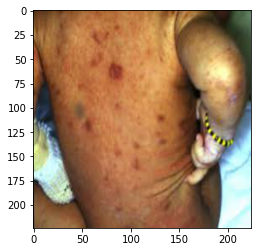

Label yang benar adalah: 1 : Scabies
Nilai yang diprediksi adalah: [0.132832   0.5982342  0.26893377]
Label yang diprediksi adalah: 1 : Scabies
Prediksi benar


In [ ]:
n = 23 #Don't exceed (value fro test image - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[0.83 0.17 0.  ]
 [0.   0.92 0.08]
 [0.   0.   1.  ]]
                  precision    recall  f1-score   support

        Ringworm       1.00      0.83      0.91        12
         Scabies       0.85      0.92      0.88        12
Tinea Versicolor       0.92      1.00      0.96        12

        accuracy                           0.92        36
       macro avg       0.92      0.92      0.92        36
    weighted avg       0.92      0.92      0.92        36



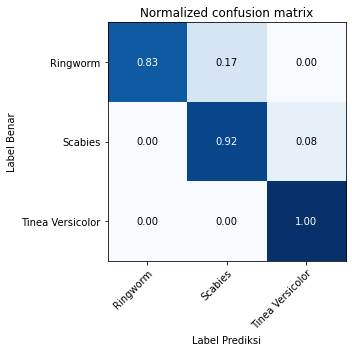

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

print(classification_report(y_true, y_pred, target_names=labels))

**Save the model using tf.saved_model.save and then convert the saved model to a tflite compatible format.**

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Diagnosis_Penyakit_Kulit_NASNetMobile.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets


INFO:tensorflow:Assets written to: save/model/assets
